**Task 1 – Machine Learning project**

*Welcome to Machine Learning. We are predicting airbnb prices in NewYork*

*This notebook contains all the sample code.*

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
#imports
from __future__ import division, print_function, unicode_literals
import numpy as np
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

# Plot Configurations
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "airbnb"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)

warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

The data set was provided from Kaggle at this link (https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data).

In [3]:
AIR_BNB_PATH = os.path.join("datasets", "new-york-city-airbnb-open-data")

In [4]:
def load_air_bnb_data(air_bnb_path=AIR_BNB_PATH):
    csv_path = os.path.join(AIR_BNB_PATH, "AB_NYC_2019.csv")
    return pd.read_csv(csv_path)

In [5]:
bnb = load_air_bnb_data()

# Explore the data

In [6]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

The features last_review and reviews_per_month have the same number of null values which implies that the only way reviews_per_month is null is if the property has never had a review. last_review is likely irrelevent but I belive reviews_per_month might be useful. I think it would make sense to replace null values with zero for reviews_per_month. 

In [7]:
bnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
bnb["room_type"].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [8]:
bnb["neighbourhood_group"].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [9]:
bnb.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [10]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Saving figure attribute_histogram_plots


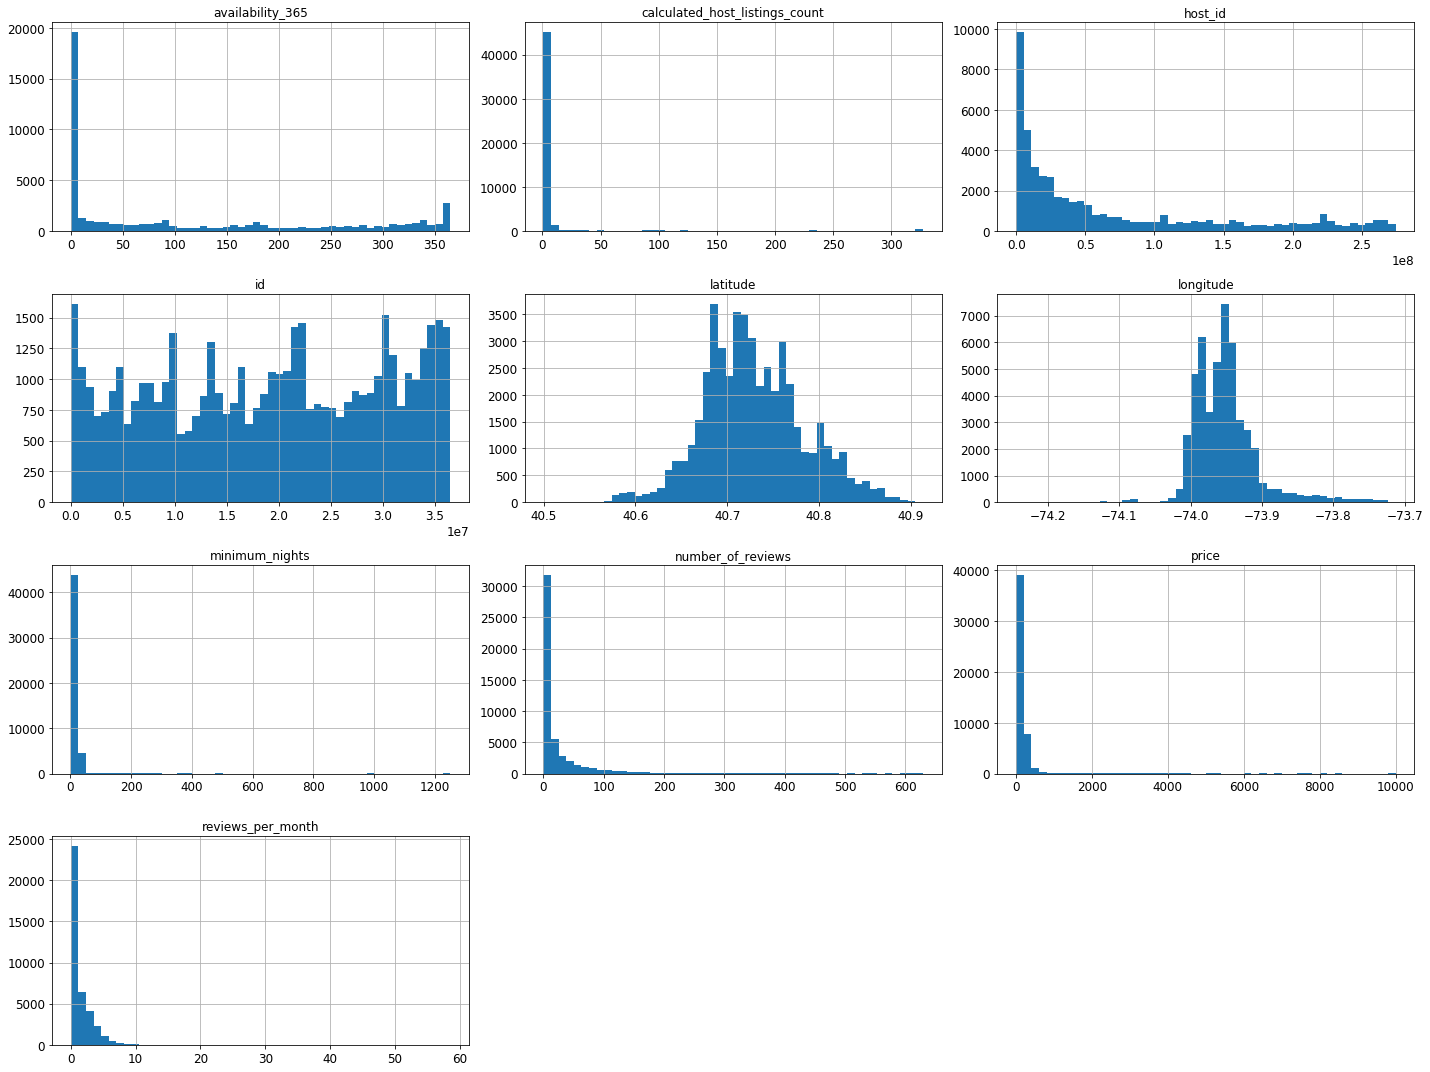

In [11]:
%matplotlib inline

bnb.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# Prepare the data for visualization

The data is split into a training and test set with a 80/20 ratio.

In [36]:
train_set, test_set = train_test_split(bnb, test_size=0.2, random_state=42)

We create a new feature call price_cat that divides price into bins of size 50.

In [37]:
bnb["price_cat"] = pd.cut(bnb["price"],
                               bins=[-1.0,50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0 ,bnb["price"].max()],
                               labels=[25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0 , 425.0, 475.0])

In [38]:
bnb.isnull().sum()

id                                   0
name                                14
host_id                              0
host_name                           18
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       8032
reviews_per_month                 8032
calculated_host_listings_count       0
availability_365                     0
price_cat                            0
dtype: int64

Here we generate stratified training and testing sets.

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(bnb, bnb["price_cat"]):
    strat_train_set = bnb.loc[train_index]
    strat_test_set = bnb.loc[test_index]

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


Here we can see the proportions in each price scategory for the stratified test set vs. the total set. 

In [40]:
strat_test_set["price_cat"].value_counts() / len(strat_test_set)

75.0     0.283870
125.0    0.175230
175.0    0.104550
25.0     0.104294
225.0    0.048569
275.0    0.029397
475.0    0.021217
325.0    0.011759
375.0    0.011247
425.0    0.004473
Name: price_cat, dtype: float64

In [41]:
bnb["price_cat"].value_counts() / len(bnb)

75.0     0.355200
125.0    0.205108
25.0     0.134191
175.0    0.134037
225.0    0.064961
275.0    0.037862
475.0    0.029451
325.0    0.018432
375.0    0.014163
425.0    0.006596
Name: price_cat, dtype: float64

In [42]:
def income_cat_proportions(data):
    return data["price_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(bnb, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(bnb),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [43]:
def price_cat_proportions(data):
    return data["pice_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(bnb, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(bnb),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [44]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
25.0,0.134191,0.104294,0.129218,-3.705789,-22.278857
75.0,0.355200,0.283870,0.359535,1.220396,-20.081585
125.0,0.205108,0.175230,0.201304,-1.854733,-14.566882
175.0,0.134037,0.104550,0.130240,-2.832748,-21.999203
225.0,0.064961,0.048569,0.068507,5.459503,-25.233934
275.0,0.037862,0.029397,0.039238,3.635587,-22.357703
325.0,0.018432,0.011759,0.019555,6.091786,-36.206246
375.0,0.014163,0.011247,0.014954,5.584871,-20.585738
425.0,0.006596,0.004473,0.007157,8.516035,-32.177478
475.0,0.029451,0.021217,0.030291,2.854065,-27.958756


In [30]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("price_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights

In [31]:
bnb = strat_train_set.copy()

Saving figure bad_visualization_plot


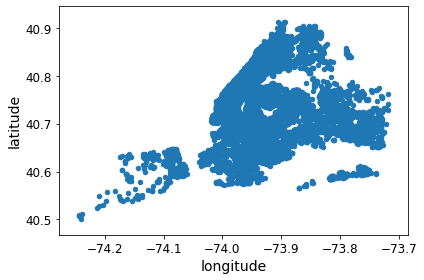

In [32]:
bnb.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


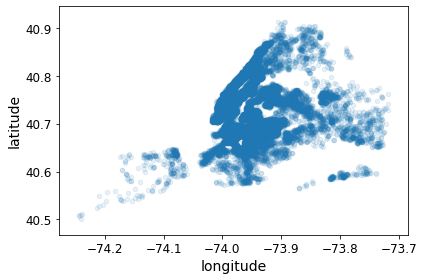

In [33]:
bnb.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

In [59]:
bnb.describe()
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_cat
28149,21948222,Serene 2 bed w/ private backyard - flatbush di...,2300590,Bess,Brooklyn,Flatbush,40.64495,-73.95760,Entire home/apt,95,3,2,2018-01-06,0.10,1,0,75.0
34692,27520341,"New condo in LES/China Town, elevator",55149412,Ha,Manhattan,Chinatown,40.71579,-73.99285,Private room,130,3,0,NaN,NaN,4,222,125.0
6465,4701802,Boerum Hill Brownstone with Skylights,10568263,Stephanie,Brooklyn,Boerum Hill,40.68518,-73.98530,Entire home/apt,190,2,8,2019-06-08,0.87,1,0,175.0
39029,30495063,Chic & Bright Brooklyn Bungalow,33988719,Fenice,Brooklyn,Bushwick,40.69056,-73.91596,Private room,90,3,0,NaN,NaN,1,176,75.0
35770,28386154,Charming Bedroom in Brooklyn Navy Yard,30185638,Nima,Brooklyn,Fort Greene,40.69633,-73.97215,Private room,85,5,29,2019-06-18,2.91,1,240,75.0


Saving figure housing_prices_scatterplot


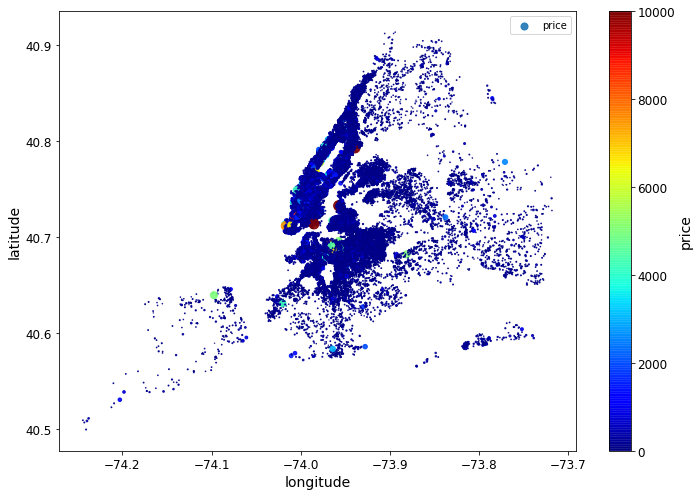

In [69]:
bnb.plot(kind="scatter", x="longitude", y="latitude", alpha=0.9,
    s=bnb["price"]/100, label="price", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [46]:
#NY_img.extent=[ -74.0, -73.0, 40.0, 41.0],

Saving figure california_housing_prices_plot


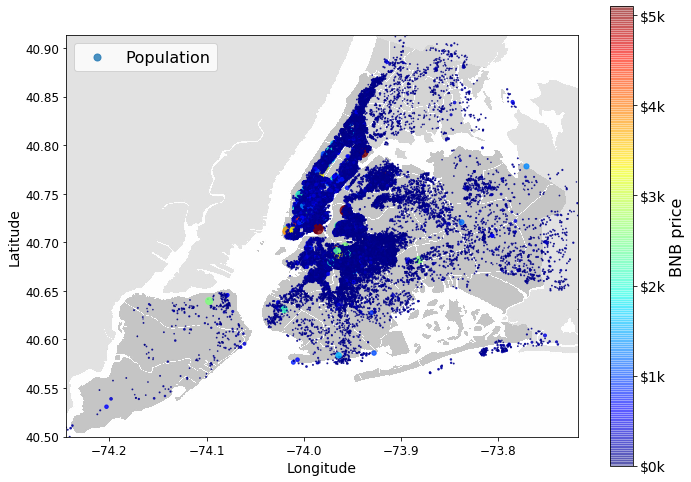

In [51]:
import matplotlib.image as mpimg
NY_img=mpimg.imread(PROJECT_ROOT_DIR + r'/datasets/new-york-city-airbnb-open-data/New_York_City_.png',0)
ax = bnb.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=bnb['price']/100, label="Population",
                       c="price", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.8,sharex=False
                      )

plt.imshow(NY_img,  alpha=0.4,extent=[bnb["longitude"].min(), bnb["longitude"].max(), bnb["latitude"].min(), bnb["latitude"].max()],
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = bnb["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('BNB price', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [49]:
corr_matrix = bnb.corr()

In [50]:
corr_matrix["price"].sort_values(ascending=False)

price                             1.000000
availability_365                  0.081847
calculated_host_listings_count    0.057462
minimum_nights                    0.042805
latitude                          0.033899
host_id                           0.015294
id                                0.010639
reviews_per_month                -0.030575
number_of_reviews                -0.047926
longitude                        -0.149954
Name: price, dtype: float64

Saving figure scatter_matrix_plot


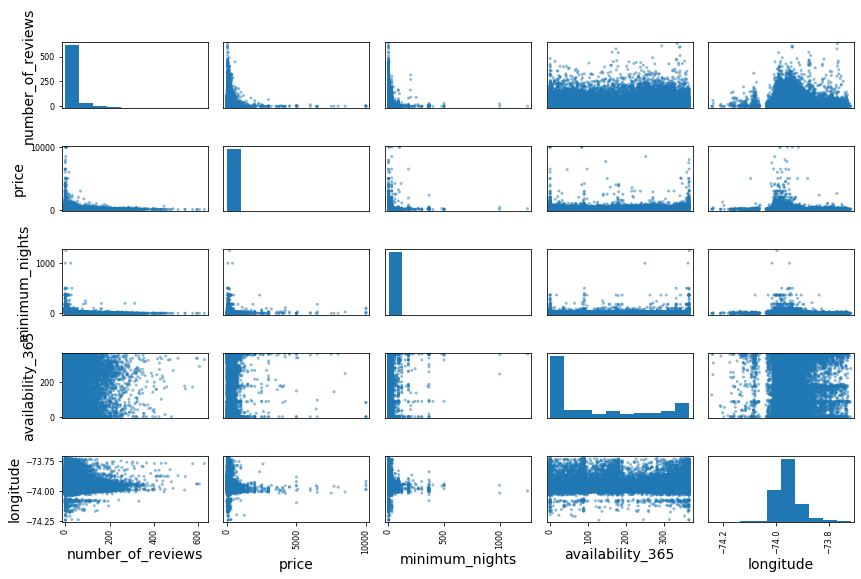

In [52]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["number_of_reviews", "price", "minimum_nights",
              "availability_365","longitude"]
scatter_matrix(bnb[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

# Prepare the data for Machine Learning algorithms

First, we drop the labels from the training set. 

In [52]:
bnb = strat_train_set.drop("price", axis=1) # drop labels for training set
bnb_labels = strat_train_set["price"].copy()

In [71]:
sample_incomplete_rows = bnb[bnb.isnull().any(axis=1)].head()
bnb.isnull().sum()

id                                   0
name                                14
host_id                              0
host_name                           18
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       8032
reviews_per_month                 8032
calculated_host_listings_count       0
availability_365                     0
price_cat                            0
dtype: int64

Here I think it might want to keep reviews per month and just repalce them with zero. 

In [55]:
sample_incomplete_rows.dropna(subset=["reviews_per_month"])    # option 1

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_cat


In [56]:
sample_incomplete_rows.drop("reviews_per_month", axis=1)       # option 2

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365,price_cat
45088,34517667.0,775 sqft Park Ave. Suite near Flatiron & Union Sq,260577152.0,Royalton Park Avenue,Manhattan,Midtown,40.74311,-73.98675,Private room,1.0,0.0,NaN,10.0,362.0,275.0
27555,21683672.0,Prime UWS location bedroom available!,2179407.0,Edgar,Manhattan,Upper West Side,40.78720,-73.97639,Private room,2.0,0.0,NaN,1.0,0.0,75.0
29807,22929942.0,Spacious 1 Bed in Prime Williamsburg (big balc...,25339875.0,Rotem,Brooklyn,Greenpoint,40.72017,-73.95352,Entire home/apt,6.0,0.0,NaN,1.0,0.0,125.0
14247,11037105.0,Sunny in heart of Williamsburg,57275881.0,Allegra,Brooklyn,Williamsburg,40.71187,-73.95566,Entire home/apt,1.0,0.0,NaN,1.0,0.0,225.0
29487,22631676.0,"Peaceful, Spacious King-Size Bedroom with Sunl...",41311743.0,Jean,Brooklyn,Crown Heights,40.67516,-73.94813,Private room,3.0,0.0,NaN,2.0,0.0,75.0


In [57]:
median = bnb["reviews_per_month"].median()
sample_incomplete_rows["reviews_per_month"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_cat
45088,34517667.0,775 sqft Park Ave. Suite near Flatiron & Union Sq,260577152.0,Royalton Park Avenue,Manhattan,Midtown,40.74311,-73.98675,Private room,1.0,0.0,NaN,0.72,10.0,362.0,275.0
27555,21683672.0,Prime UWS location bedroom available!,2179407.0,Edgar,Manhattan,Upper West Side,40.78720,-73.97639,Private room,2.0,0.0,NaN,0.72,1.0,0.0,75.0
29807,22929942.0,Spacious 1 Bed in Prime Williamsburg (big balc...,25339875.0,Rotem,Brooklyn,Greenpoint,40.72017,-73.95352,Entire home/apt,6.0,0.0,NaN,0.72,1.0,0.0,125.0
14247,11037105.0,Sunny in heart of Williamsburg,57275881.0,Allegra,Brooklyn,Williamsburg,40.71187,-73.95566,Entire home/apt,1.0,0.0,NaN,0.72,1.0,0.0,225.0
29487,22631676.0,"Peaceful, Spacious King-Size Bedroom with Sunl...",41311743.0,Jean,Brooklyn,Crown Heights,40.67516,-73.94813,Private room,3.0,0.0,NaN,0.72,2.0,0.0,75.0


**Warning**: Since Scikit-Learn 0.20, the `sklearn.preprocessing.Imputer` class was replaced by the `sklearn.impute.SimpleImputer` class.

In [58]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

In [59]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_cat
32520,25491443.0,New 4BDR LOFT in Williamsburg 2 stops to Manha...,188023318.0,Selina,Brooklyn,Greenpoint,40.72609,-73.95681,Entire home/apt,1.0,30.0,2019-06-21,2.49,4.0,63.0,475.0
17357,13696003.0,"Beautiful, well-lit pre-war apt",3792661.0,Ben,Manhattan,Morningside Heights,40.80974,-73.96034,Private room,7.0,4.0,2017-12-17,0.12,1.0,0.0,75.0
33752,26750369.0,Lovely Private Room in Heart of Prospect Heights!,4537638.0,Rachel,Brooklyn,Prospect Heights,40.67762,-73.96539,Private room,2.0,4.0,2018-09-01,0.37,1.0,0.0,75.0
14978,11924652.0,Upper west side luxury building,39111035.0,Veronica,Manhattan,Upper West Side,40.78079,-73.98826,Private room,2.0,2.0,2016-08-31,0.06,1.0,0.0,175.0
855,301034.0,Furnished Bedroom with private half bath,1550578.0,Ron,Manhattan,Harlem,40.80637,-73.95433,Private room,2.0,44.0,2019-06-26,0.49,1.0,260.0,125.0


In [60]:
#bnb_num = bnb.drop(['name',"host_name","neighbourhood_group","neighbourhood"], axis=1)
bnb_num = bnb.select_dtypes(include=[np.number])

Remove the text attribute because median can only be calculated on numerical attributes:

In [61]:
imputer.fit(bnb_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [62]:
imputer.statistics_

array([ 1.96087450e+07,  3.06924455e+07,  4.07229500e+01, -7.39556700e+01,
        2.00000000e+00,  5.00000000e+00,  7.20000000e-01,  1.00000000e+00,
        4.50000000e+01])

Check that this is the same as manually computing the median of each attribute:

In [63]:
bnb_num.median().values

array([ 1.96087450e+07,  3.06924455e+07,  4.07229500e+01, -7.39556700e+01,
        2.00000000e+00,  5.00000000e+00,  7.20000000e-01,  1.00000000e+00,
        4.50000000e+01])

Transform the training set:

In [64]:
X = imputer.transform(bnb_num)

In [65]:
bnb_tr = pd.DataFrame(X, columns=bnb_num.columns,
                          index=bnb.index)

In [66]:
bnb_tr.loc[sample_incomplete_rows.index.values]

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
45088,34517667.0,260577152.0,40.74311,-73.98675,1.0,0.0,0.72,10.0,362.0
27555,21683672.0,2179407.0,40.78720,-73.97639,2.0,0.0,0.72,1.0,0.0
29807,22929942.0,25339875.0,40.72017,-73.95352,6.0,0.0,0.72,1.0,0.0
14247,11037105.0,57275881.0,40.71187,-73.95566,1.0,0.0,0.72,1.0,0.0
29487,22631676.0,41311743.0,40.67516,-73.94813,3.0,0.0,0.72,2.0,0.0


In [67]:
imputer.strategy

'median'

In [68]:
bnb_tr = pd.DataFrame(X, columns=bnb_num.columns,
                          index=bnb_num.index)
bnb_tr.head()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
32520,25491443.0,188023318.0,40.72609,-73.95681,1.0,30.0,2.49,4.0,63.0
17357,13696003.0,3792661.0,40.80974,-73.96034,7.0,4.0,0.12,1.0,0.0
33752,26750369.0,4537638.0,40.67762,-73.96539,2.0,4.0,0.37,1.0,0.0
14978,11924652.0,39111035.0,40.78079,-73.98826,2.0,2.0,0.06,1.0,0.0
855,301034.0,1550578.0,40.80637,-73.95433,2.0,44.0,0.49,1.0,260.0


Now let's preprocess the categorical input feature, `room_type`:

In [69]:
bnb_cat = bnb[['room_type']]
bnb_cat.head(10)

,room_type
32520,Entire home/apt
17357,Private room
33752,Private room
14978,Private room
855,Private room
13540,Private room
34666,Private room
29834,Entire home/apt
45088,Private room
1906,Entire home/apt


In [70]:
bnb_cat = bnb_cat.dropna()

**Warning**: earlier versions of the book used the `LabelEncoder` class or Pandas' `Series.factorize()` method to encode string categorical attributes as integers. However, the `OrdinalEncoder` class that was introduced in Scikit-Learn 0.20 (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)) is preferable since it is designed for input features (`X` instead of labels `y`) and it plays well with pipelines (introduced later in this notebook). If you are using an older version of Scikit-Learn (<0.20), then you can import it from `future_encoders.py` instead.

In [71]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [72]:
# bnb = bnb.dropna()

In [73]:
# bnb.info()

In [74]:
# bnb.isnull().any().sum()

In [75]:
ordinal_encoder = OrdinalEncoder()
bnb_cat_encoded = ordinal_encoder.fit_transform(bnb_cat)
bnb_cat_encoded[:10]

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.]])

In [76]:
ordinal_encoder.categories_

[array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)]

**Warning**: earlier versions of the book used the `LabelBinarizer` or `CategoricalEncoder` classes to convert each categorical value to a one-hot vector. It is now preferable to use the `OneHotEncoder` class. Since Scikit-Learn 0.20 it can handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)), not just integer categorical inputs. If you are using an older version of Scikit-Learn, you can import the new version from `future_encoders.py`:

In [77]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
bnb_cat_1hot = cat_encoder.fit_transform(bnb_cat)
bnb_cat_1hot

<39098x3 sparse matrix of type '<class 'numpy.float64'>'
	with 39098 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [78]:
bnb_cat_1hot.toarray()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [79]:
cat_encoder = OneHotEncoder(sparse=False)
bnb_cat_1hot = cat_encoder.fit_transform(bnb_cat)
bnb_cat_1hot

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [80]:
cat_encoder.categories_

[array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)]

Let's create a custom transformer to add extra attributes:

In [81]:
bnb.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'price_cat'],
      dtype='object')

## Let us fix the rest later. I stopped here for now. October 10, 2019

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

NameError: name 'housing' is not defined

Alternatively, you can use Scikit-Learn's `FunctionTransformer` class that lets you easily create a transformer based on a transformation function (thanks to [Hanmin Qin](https://github.com/qinhanmin2014) for suggesting this code). Note that we need to set `validate=False` because the data contains non-float values (`validate` will default to `False` in Scikit-Learn 0.22).

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

Now let's build a pipeline for preprocessing the numerical attributes (note that we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that was introduced in Scikit-Learn 0.20. If you are using an older version of Scikit-Learn, you can import it from `future_encoders.py`:

In [ ]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

In [ ]:
housing_prepared.shape

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features (again, we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

The result is the same as with the `ColumnTransformer`:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

# Select and train a model 

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

In [ ]:
some_data_prepared

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Fine-tune your model

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

**Note**: we specify `n_estimators=10` to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

We could compute the interval manually like this:

In [ ]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

Alternatively, we could use a z-scores rather than t-scores:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)